<a href="https://colab.research.google.com/github/Chris-Congleton/Chris-Congleton/blob/main/ReverbChannelTestData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U gensim
!pip install pyLDAvis

import json, os
import pandas as pd
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')
import seaborn as sns

# regular expression library
import re
# wordcloud library
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

import gensim.corpora as corpora
from pprint import pprint


import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
path_ftm = 'gdrive/MyDrive/CS/Thesis/rc_testdata/ftm-nl.article-cleansed-1000-articles.json'
path_joop = 'gdrive/MyDrive/CS/Thesis/rc_testdata/joop-bnnvara-nl.article-cleansed-1000-articles.json'
path_nos = 'gdrive/MyDrive/CS/Thesis/rc_testdata/nos-nl.article-cleansed-1000-articles.json'
path_nu = 'gdrive/MyDrive/CS/Thesis/rc_testdata/nu-nl.article-cleansed-1000-articles.json'
path_volkskrant = 'gdrive/MyDrive/CS/Thesis/rc_testdata/volkskrant-nl.article-cleansed-1000-articles.json'

In [4]:
df_ftm = pd.read_json(path_ftm)
df_joop = pd.read_json(path_joop)
df_nos = pd.read_json(path_nos)
df_nu = pd.read_json(path_nu)
df_volkskrant = pd.read_json(path_volkskrant)

In [5]:
df_ftm["Bron"] = "Follow The Money"
df_joop["Bron"] = "Joop"
df_nos["Bron"] = "NOS"
df_nu["Bron"] = "Nu"
df_volkskrant["Bron"] = "Volkskrant"

dfs = [df_joop, df_ftm, df_nos, df_nu, df_volkskrant]
df_all = pd.concat(dfs, ignore_index=True)

df_all.head()

,categories,cleaned,cleantext,id,keywords,leading-image,leading-image-caption-content,leading-image-caption-source,leading-image-copyright,og-description,og-image,og-title,structure,timestamp,title,url,Bron,html_raw,page_json
0,Video,2019-04-21T11:10:19.878000,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,159241,"[Brexit, Buitenhof, Europa, Europese Unie, Fra...",NaN,,,,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,https://joop.bnnvara.nl/content/uploads/2019/0...,Frans Timmermans: de staat van Europa na weer ...,"\n\t\t<p>Hoe staat Europa ervoor na <a href=""h...",2019-04-14 13:51:58,Frans Timmermans: de staat van Europa na weer ...,https://joop.bnnvara.nl/videos/frans-timmerman...,Joop,NaN,NaN
1,Opinie,2019-04-21T11:10:19.381000,In Frankrijk is ophef ontstaan rond kritiek op...,159237,"[Frankrijk, Hervé di Rosa, Kunst, Racisme, Ste...",NaN,,,,Niemand mag in een vrije maatschappij de macht...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Han van der Horst: Zijn die werken van ...,\n \n\t\t<p>In Frankrijk is ophef ontst...,2019-04-14 12:41:28,Zijn die werken van Hervé di Rosa wel zo racis...,https://joop.bnnvara.nl/opinies/zijn-die-werke...,Joop,NaN,NaN
2,Nieuws,2019-04-21T11:10:18.678000,Twee Franse academici zijn een petitie begonne...,159213,"[Afrika, Frankrijk, Kolonialisme, Racisme]",NaN,,,,Twee Franse academici zijn een petitie begonne...,https://joop.bnnvara.nl/content/uploads/2019/0...,Academici willen racistische muurschildering u...,\n ...,2019-04-14 09:56:04,Academici willen racistische muurschildering u...,https://joop.bnnvara.nl/nieuws/academici-wille...,Joop,NaN,NaN
3,Opinie,2019-04-21T11:10:17.576000,Foto: ANP | Sander Koning Het was afgelopen ma...,159230,"[Forum voor Democratie, GroenLinks, Jesse Klav...",NaN,,,,GroenLinks moet oppassen dat ze niet voor lang...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Joost van Spanje: Weglopen van de wegloper,"\n \n\t\t<figure id=""attachment_159231""...",2019-04-14 09:12:48,Weglopen van de wegloper,https://joop.bnnvara.nl/opinies/weglopen-van-d...,Joop,NaN,NaN
4,Nieuws,2019-04-21T11:10:16.926000,Op 2 april 2019 was de opening van de Vrijheid...,159226,"[Jonathan Holslag, Vrijheid, Vrijheidscolleges]",NaN,,,,Op 2 april 2019 was de opening van de Vrijheid...,https://joop.bnnvara.nl/content/uploads/2019/0...,Vrijheidscollege Jonathan Holslag: &#039;Strij...,\n ...,2019-04-14 09:01:51,Vrijheidscollege Jonathan Holslag: &#8216;Stri...,https://joop.bnnvara.nl/nieuws/vrijheidscolleg...,Joop,NaN,NaN


In [6]:
df_all.head()

,categories,cleaned,cleantext,id,keywords,leading-image,leading-image-caption-content,leading-image-caption-source,leading-image-copyright,og-description,og-image,og-title,structure,timestamp,title,url,Bron,html_raw,page_json
0,Video,2019-04-21T11:10:19.878000,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,159241,"[Brexit, Buitenhof, Europa, Europese Unie, Fra...",NaN,,,,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,https://joop.bnnvara.nl/content/uploads/2019/0...,Frans Timmermans: de staat van Europa na weer ...,"\n\t\t<p>Hoe staat Europa ervoor na <a href=""h...",2019-04-14 13:51:58,Frans Timmermans: de staat van Europa na weer ...,https://joop.bnnvara.nl/videos/frans-timmerman...,Joop,NaN,NaN
1,Opinie,2019-04-21T11:10:19.381000,In Frankrijk is ophef ontstaan rond kritiek op...,159237,"[Frankrijk, Hervé di Rosa, Kunst, Racisme, Ste...",NaN,,,,Niemand mag in een vrije maatschappij de macht...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Han van der Horst: Zijn die werken van ...,\n \n\t\t<p>In Frankrijk is ophef ontst...,2019-04-14 12:41:28,Zijn die werken van Hervé di Rosa wel zo racis...,https://joop.bnnvara.nl/opinies/zijn-die-werke...,Joop,NaN,NaN
2,Nieuws,2019-04-21T11:10:18.678000,Twee Franse academici zijn een petitie begonne...,159213,"[Afrika, Frankrijk, Kolonialisme, Racisme]",NaN,,,,Twee Franse academici zijn een petitie begonne...,https://joop.bnnvara.nl/content/uploads/2019/0...,Academici willen racistische muurschildering u...,\n ...,2019-04-14 09:56:04,Academici willen racistische muurschildering u...,https://joop.bnnvara.nl/nieuws/academici-wille...,Joop,NaN,NaN
3,Opinie,2019-04-21T11:10:17.576000,Foto: ANP | Sander Koning Het was afgelopen ma...,159230,"[Forum voor Democratie, GroenLinks, Jesse Klav...",NaN,,,,GroenLinks moet oppassen dat ze niet voor lang...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Joost van Spanje: Weglopen van de wegloper,"\n \n\t\t<figure id=""attachment_159231""...",2019-04-14 09:12:48,Weglopen van de wegloper,https://joop.bnnvara.nl/opinies/weglopen-van-d...,Joop,NaN,NaN
4,Nieuws,2019-04-21T11:10:16.926000,Op 2 april 2019 was de opening van de Vrijheid...,159226,"[Jonathan Holslag, Vrijheid, Vrijheidscolleges]",NaN,,,,Op 2 april 2019 was de opening van de Vrijheid...,https://joop.bnnvara.nl/content/uploads/2019/0...,Vrijheidscollege Jonathan Holslag: &#039;Strij...,\n ...,2019-04-14 09:01:51,Vrijheidscollege Jonathan Holslag: &#8216;Stri...,https://joop.bnnvara.nl/nieuws/vrijheidscolleg...,Joop,NaN,NaN


In [7]:
# Remove the columns
articles = df_all.drop(columns=['id', 'keywords',
                                'leading-image', 'leading-image-caption-content',
                                'leading-image-caption-source', 'leading-image-copyright',
                                'og-description', 'og-image', 'og-title',
                                'structure', 'url', 'html_raw', 'page_json',
                                'categories', 'cleaned'], axis=1)# Print out the first rows of papers
articles.head()

,cleantext,timestamp,title,Bron
0,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,2019-04-14 13:51:58,Frans Timmermans: de staat van Europa na weer ...,Joop
1,In Frankrijk is ophef ontstaan rond kritiek op...,2019-04-14 12:41:28,Zijn die werken van Hervé di Rosa wel zo racis...,Joop
2,Twee Franse academici zijn een petitie begonne...,2019-04-14 09:56:04,Academici willen racistische muurschildering u...,Joop
3,Foto: ANP | Sander Koning Het was afgelopen ma...,2019-04-14 09:12:48,Weglopen van de wegloper,Joop
4,Op 2 april 2019 was de opening van de Vrijheid...,2019-04-14 09:01:51,Vrijheidscollege Jonathan Holslag: &#8216;Stri...,Joop


In [8]:
# Remove punctuation
articles['cleantext_processed'] = \
articles['cleantext'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
articles['cleantext_processed'] = \
articles['cleantext_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
articles['cleantext_processed'].head()

<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<ipython-input-8-341723ed8bf8>:2: DeprecationWarning: invalid escape sequence \.
  articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\.!?]', '', x))


0    hoe staat europa ervoor na w&eacute;&eacute;r ...
1    in frankrijk is ophef ontstaan rond kritiek op...
2    twee franse academici zijn een petitie begonne...
3    foto: anp | sander koning het was afgelopen ma...
4    op 2 april 2019 was de opening van de vrijheid...
Name: cleantext_processed, dtype: object

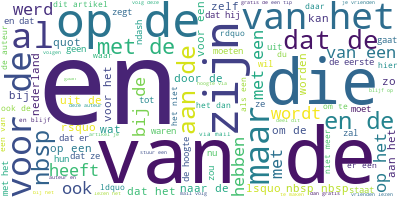

In [14]:
# Join the different processed titles together.
long_string = ','.join(list(articles['cleantext_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [10]:
stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo' ])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = articles.cleantext_processed.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['staat', 'europa', 'ervoor', 'eacute', 'eacute', 'brexit', 'uitstel', 'vooravond', 'europese', 'verkiezingen', 'vanwege', 'uitstel', 'verenigd', 'koninkrijk', 'verplicht', 'mee', 'verkiezingen', 'betekent', 'verhoudingen', 'europees', 'parlement', 'ondanks', 'puinhoop', 'onzekerheid', 'naderende', 'brexit', 'verenigd', 'koninkrijk', 'meebrengt', 'klinkt']


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 2), (5, 2), (6, 5), (7, 2), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 3), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [21]:
# number of topics
num_topics = 40
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(4,
  '0.004*"jaar" + 0.004*"wel" + 0.004*"we" + 0.004*"beeld" + 0.003*"gaan" + '
  '0.003*"twee" + 0.003*"waar" + 0.003*"gaat" + 0.002*"nederland" + '
  '0.002*"alleen"'),
 (19,
  '0.005*"jaar" + 0.004*"wel" + 0.004*"we" + 0.003*"beeld" + 0.003*"gaat" + '
  '0.003*"waar" + 0.002*"zegt" + 0.002*"week" + 0.002*"zoals" + 0.002*"goed"'),
 (33,
  '0.004*"video" + 0.003*"jaar" + 0.003*"we" + 0.003*"wel" + 0.003*"eerste" + '
  '0.002*"goed" + 0.002*"twee" + 0.002*"spelen" + 0.002*"gaan" + 0.002*"weer"'),
 (2,
  '0.006*"jaar" + 0.006*"we" + 0.004*"wel" + 0.004*"mensen" + 0.003*"waar" + '
  '0.003*"beeld" + 0.003*"staat" + 0.003*"nieuwe" + 0.003*"twee" + '
  '0.002*"alle"'),
 (24,
  '0.006*"jaar" + 0.005*"we" + 0.004*"wel" + 0.004*"gaat" + 0.003*"zegt" + '
  '0.003*"beeld" + 0.003*"nieuwe" + 0.003*"waar" + 0.002*"nederland" + '
  '0.002*"maken"'),
 (7,
  '0.006*"jaar" + 0.005*"wel" + 0.003*"gaan" + 0.003*"waar" + 0.003*"beeld" + '
  '0.003*"we" + 0.003*"gaat" + 0.002*"volgens" + 0.002*"weer" 

In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.020289 -0.003084       1        1  10.037228
39     0.017229 -0.005034       2        1   7.650744
26     0.017837 -0.006277       3        1   7.031846
5      0.004633 -0.001729       4        1   6.376444
12    -0.001668  0.008113       5        1   5.571781
30     0.010946  0.004220       6        1   5.347011
11     0.013093  0.005391       7        1   5.161904
20     0.017864  0.003766       8        1   4.413190
15     0.004948  0.005068       9        1   3.456340
38     0.003207  0.001374      10        1   3.086315
24     0.013251 -0.006551      11        1   2.746371
25     0.005807 -0.001299      12        1   2.592975
27     0.004979  0.011271      13        1   2.416287
28     0.006743 -0.004573      14        1   2.349516
9      0.013987 -0.005676      15        1   2.305627
35    -0.002903  0.011072      16        1   2.236116
31    -0.027259 -0.025532      17        1   2.211928
7      0.006225  0.002876      18        1   2.160370
4     -0.016858  0.007669      19        1   1.798861
22     0.003997 -0.008584      20        1   1.680972
3      0.006988  0.019046      21        1   1.529023
19     0.003560 -0.003044      22        1   1.508033
37     0.000484 -0.000075      23        1   1.281637
17    -0.005734  0.004752      24        1   1.261206
10    -0.004513  0.010654      25        1   1.208434
36     0.000049 -0.001821      26        1   1.203321
0      0.006811  0.012195      27        1   1.161802
34     0.002453 -0.012470      28        1   1.088793
29     0.000114  0.011282      29        1   1.004636
21    -0.001323  0.011879      30        1   0.941911
1     -0.004972 -0.016063      31        1   0.888726
32     0.006769 -0.009596      32        1   0.846244
33    -0.032594  0.000612      33        1   0.825824
14    -0.040660  0.021713      34        1   0.779293
16    -0.008573 -0.005854      35        1   0.741288
23    -0.023762 -0.001712      36        1   0.667243
6     -0.005913  0.005871      37        1   0.662889
8     -0.011480 -0.028365      38        1   0.648736
13    -0.003640 -0.035994      39        1   0.633062
18    -0.000413  0.024507      40        1   0.486076, topic_info=             Term         Freq        Total Category  logprob  loglift
509            we  6747.000000  6747.000000  Default  30.0000  30.0000
219          jaar  5724.000000  5724.000000  Default  29.0000  29.0000
423           wel  4805.000000  4805.000000  Default  28.0000  28.0000
1603        beeld  3495.000000  3495.000000  Default  27.0000  27.0000
74           waar  3130.000000  3130.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
17         eerste     8.821364  2195.977256  Topic40  -6.5115  -0.1906
56          staat     8.724519  2104.111696  Topic40  -6.5225  -0.1590
287     nederland     9.062807  2678.568363  Topic40  -6.4845  -0.3623
1028  nederlandse     8.242908  1834.135591  Topic40  -6.5793  -0.0784
515         zoals     8.156241  1798.264463  Topic40  -6.5899  -0.0692

[3322 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
92384      9  0.406351      aandachtige
92970      1  0.670436          aanraad
87812      3  0.883726       aanraadden
78257     11  0.806861     aanstellerig
11683      1  0.236580         aantreft
...      ...       ...              ...
15076     19  0.035270     zwangerschap
15076     20  0.035270     zwangerschap
15076     24  0.176349     zwangerschap
92396      9  0.400703  zwartgeblakerde
78469      8  0.649846         zwelgend

[13975 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 40, 27, 6, 13, 31, 12, 21, 16, 39, 25, 26, 28, 29, 10, 36, 32, 8, 5, 23, 4, 20, 38, 18, 11, 37, 1, 35, 30, 22, 2, 33, 34, 15, 17, 24, 7, 9, 14, 19])